### Principal Component Analysis:
1. Objective - write code in python to perform PCA and understand why we need such unsupervised learning methods.
2. First, let us understand the importance of PCA:
   
    Imagine you have to make an important decision whether to invest in a stock or not, for it you collected a whole dataset from the NSE or Bombay Stock Exchange maybe. Before opening the dataset, you thought it would be easier to predict in which stock to invest, whichever would have low risk, higher returns, less volatility, I will invest in that.
   But the story changed when you opened the dataset, it has 100s of features on which the decision of previous stockholders depended!!!
   You got panicked, but here comes the role of PCA (principal component).
   It helps us select **The most important** dimensions(here features) which will explain almost all the variance in the dataset. By using PCA, we can select the independent dimensions having highest variances and very low covariance with each other. Most of the times, it is the case that maximum 10 components are enough to explain more than 90% of variance of the total 100% explained by the 100 features. So, we compromise only a little for a big save in computational time and memory requirements.
3. Process of calculation of principal components: We first compute the matrix AtA (or AAt if rows are the features). Then PCs are nothing but the first k eigenvectors having eigenvalues in descending order (starting from largest). What is k? It depends on how much variance you are happy to be explained by those principal components together, these are values like 85%, 90% and so on.
4. Now, let's see the working of PCA in code:

In [22]:
# Loading and PreProcessing the data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gzip
# File-1
# Loading class labels (1 = ER+ , 0 = ER-)
class_labels = pd.read_csv('./class.tsv', sep='\t', header=None)
labels = class_labels[0].values

# for debugging only
# with gzip.open('data/columns.tsv.gz', 'rt') as f:
#     for i in range(10):
#         print(f.readline())



# File-2
# Loading gene name mapping
with gzip.open('./columns.tsv.gz', 'rt') as f:
    # gene_mapping = pd.read_csv(f, sep='\t', header=None, engine='python')
    lines = [line for line in f if not line.startswith('#')]

from io import StringIO
filtered_content = StringIO(''.join(lines))
gene_mapping = pd.read_csv(filtered_content, sep='\t')
# print(gene_mapping.head)
# print(gene_mapping.columns)
# count = 0
# for i in gene_mapping['ID']:
#     if i == 4404:
#         count += 1
# print(count)

# parsed_lines = []
# for line in lines:
#     parts = line.strip().split('\t')
#     if len(parts) >= 2:
#         parsed_lines.append(parts[:2])

# gene_mapping = pd.DataFrame(parsed_lines, columns = ['ID', 'Gene_Symbol'])
# with gzip.open('data/columns.tsv.gz', 'rt') as f:
#     gene_mapping = pd.read_csv(f, sep='\t', header=None, on_bad_lines='skip')

# gene_mapping.columns = ['ID', 'GeneSymbol']

# For debugging purposes only
# print(gene_mapping['GeneSymbol'].unique())






# File-3
# Loading gene expression data
with gzip.open('./filtered.tsv.gz', 'rt') as f:
    expression_data = pd.read_csv(f, sep='\t', index_col=0)

expression_data.columns = expression_data.columns.astype(str)
expression_data.columns = expression_data.columns.str.strip()   #columns were having whitespaces, that was causing problem
print(expression_data.columns)
# print('4404' in expression_data.columns)  # Should return True
# for column_name in expression_data.columns:
#     if '4404' == str(column_name).strip():
#         print("Mil gaya")
#         break
# # Find gene IDs
xbp1_id = 4404  # Given in the problem
gata3_id = gene_mapping[gene_mapping['GeneSymbol'] == 'GATA3']['ID'].values[0]

print(gata3_id)

print('4404' in expression_data.columns)
xbp1_expression = expression_data[str(xbp1_id)].values
gata3_expression = expression_data[str(gata3_id)].values

# Color map
colors = ['black' if label == 0 else 'red' for label in labels]

Index(['2', '6', '12', '13', '15', '16', '17', '20', '25', '28',
       ...
       '27622', '27623', '27633', '27634', '27638', '27641', '27642', '27643',
       '27644', '27648'],
      dtype='object', length=16173)
4359
True


In [23]:
# PCA IMPLEMENTATION
def perform_pca(X):
    # preprocessing for calculating the covariance matrix
    x_centered = X - np.mean(X, axis = 0)
    cov_matrix = np.cov(x_centered, rowvar=False)
    # Now we have to calculate the eigenvalues and eigenvectors of the covariance matrix calculated above
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    # As described above, we select the top k eigenvectors (arranged in highest-> lowest eigenvalues order)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    return eigenvectors, eigenvalues, x_centered

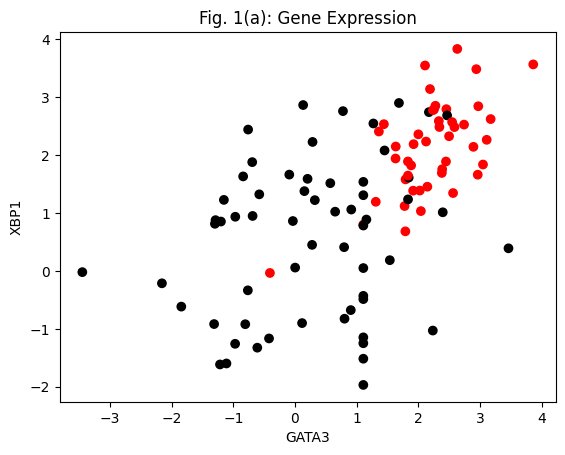

In [24]:
# Figure - 1(a) Scatter plot of xbp1 vs gata3
plt.scatter(gata3_expression, xbp1_expression, c=colors)
plt.xlabel('GATA3')
plt.ylabel('XBP1')
plt.title('Fig. 1(a): Gene Expression')
plt.savefig('figure_1a.png')
plt.show()

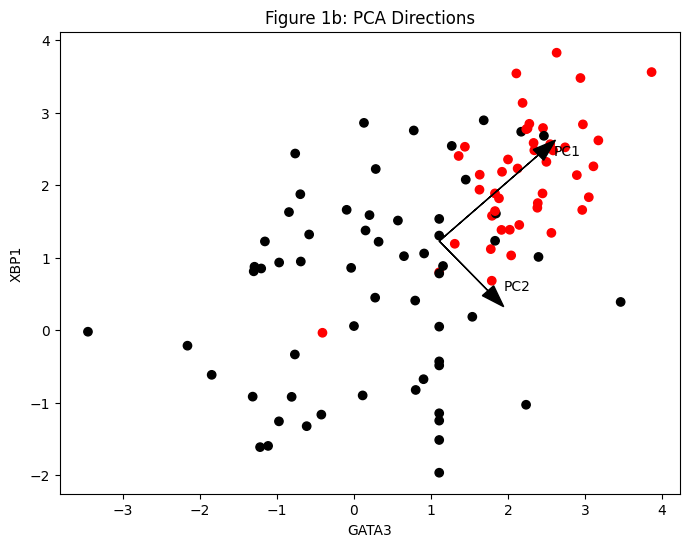

In [25]:
# Figure 1(b)
x = np.column_stack((gata3_expression, xbp1_expression))

eigenvectors, eigenvalues, x_centered = perform_pca(x)
# as can be seen from plot, two principal components are selected
pc1 = eigenvectors[:, 0]
pc2 = eigenvectors[:, 1]

# projections on the principal components - just the matrix multiplication of principal component vector and the original matrix (not the covariance one)
projection_pc1 = np.dot(x_centered, pc1)
projection_pc2 = np.dot(x_centered, pc2)

if np.mean(projection_pc1[labels == 1]) < np.mean(projection_pc1[labels == 0]):
    pc1 = -pc1
    projection_pc1 = -projection_pc1


plt.figure(figsize=(8, 6))
plt.scatter(gata3_expression, xbp1_expression, c=colors)

# Plotting the principal components directions
mean_gata3 = np.mean(gata3_expression)
mean_xbp1 = np.mean(xbp1_expression)
scale1 = np.sqrt(eigenvalues[0])
scale2 = np.sqrt(eigenvalues[1])

plt.arrow(mean_gata3, mean_xbp1, pc1[0]*scale1, pc1[1]*scale1,
          head_width=0.2, head_length=0.3, fc='black', ec='black')
plt.arrow(mean_gata3, mean_xbp1, pc2[0]*scale2, pc2[1]*scale2,
          head_width=0.2, head_length=0.3, fc='black', ec='black')

plt.text(mean_gata3 + pc1[0]*scale1 + 0.2, mean_xbp1 + pc1[1]*scale1, 'PC1')
plt.text(mean_gata3 + pc2[0]*scale2 + 0.2, mean_xbp1 + pc2[1]*scale2, 'PC2')

plt.xlabel('GATA3')
plt.ylabel('XBP1')
plt.title('Figure 1b: PCA Directions')
plt.savefig('figure_1b.png')
plt.show()

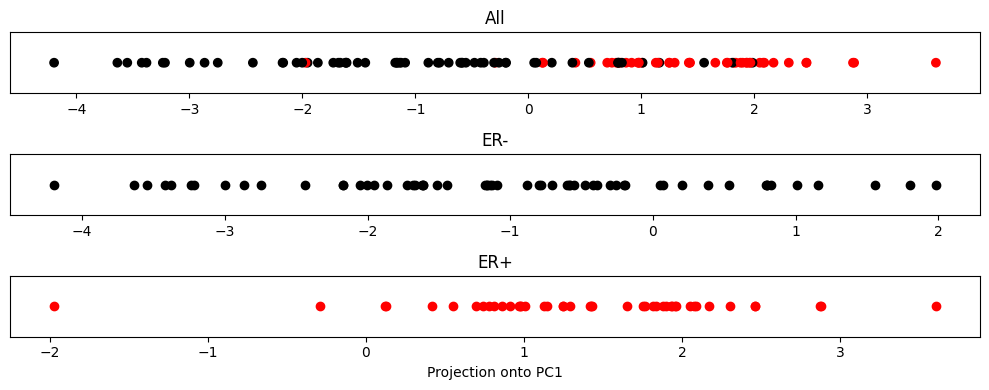

Variance explained by PC1: 0.7792
Variance explained by PC2: 0.2208


In [26]:
# Figure-(c) Projection on PC1

# Separate ER+ and ER- samples
er_pos_pc1 = projection_pc1[labels == 1]
er_neg_pc1 = projection_pc1[labels == 0]

# Create Figure 1c
plt.figure(figsize=(10, 4))

# All samples
plt.subplot(3, 1, 1)
plt.scatter(projection_pc1, np.zeros_like(projection_pc1), c=colors)
plt.yticks([])
plt.title('All')

# ER- samples
plt.subplot(3, 1, 2)
plt.scatter(er_neg_pc1, np.zeros_like(er_neg_pc1), c='black')
plt.yticks([])
plt.title('ER-')

# ER+ samples
plt.subplot(3, 1, 3)
plt.scatter(er_pos_pc1, np.zeros_like(er_pos_pc1), c='red')
plt.yticks([])
plt.title('ER+')
plt.xlabel('Projection onto PC1')

plt.tight_layout()
plt.savefig('figure_1c.png')
plt.show()

# Calculate and print variance explained
print(f"Variance explained by PC1: {eigenvalues[0]/sum(eigenvalues):.4f}")
print(f"Variance explained by PC2: {eigenvalues[1]/sum(eigenvalues):.4f}")


### How PCA is beneficial in unsupervised learning?
Pattern discovery without labels: As an unsupervised method, PCA finds intrinsic patterns in data without requiring class labels. In our example, PCA naturally separates ER+ from ER- breast cancer samples without being explicitly told about these classes...